# Customer Centric analysis of Sales Performance

### Objective:
The objective of this notebook is to analyse how the Sales Performance of a seller is related to the experience of their clients. In this case, the Sales Performance is whether a seller has an above average monthly income or not. 

### How:
The hypothesis is that the Sales Performance can be predicted by 4 features:
* The ratio of shipments within Deadline informed to the client
* The average star rating of the seller
* If the seller offers products that belong to top selling categories 
* The population density of the region in which the seller is located


# Modeling:
Decision Tree Classifiers with different max_leaf_nodes will be trained and evaluated according to their accuracies on the training and test datasets.
## Rationale
The idea is to reduce the chances of overfitting by reducing the max_leaf_nodes.

In [1]:
import pandas as pd
# from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# import math
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

features_df = pd.read_csv('/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/modelling_df.csv')

X = features_df[['within_expected_delivery_date', 'review_score', 'offer_trending_category', 'state_population_density']].values
y = features_df['above_average'].values

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

In [2]:
from sklearn.tree import DecisionTreeClassifier

max_nodes_list = []

train_score = []
train_score_std = []

val_score = []
val_score_std = []

fitted_model = []

for max_nodes in range(10, 101, 10):
    
    cv_evaluation = cross_validate(DecisionTreeClassifier(max_leaf_nodes = max_nodes)
                                   , X, y
                                   , scoring = 'accuracy', cv = 5
                                   , return_train_score = True
                                   , return_estimator = True)
    
    max_nodes_list.append(max_nodes)
    
    train_score.append(round(cv_evaluation['train_score'].mean(), 4))
    train_score_std.append(round(cv_evaluation['train_score'].std(), 4))
    
    val_score.append(round(cv_evaluation['test_score'].mean(), 4))
    val_score_std.append(round(cv_evaluation['train_score'].std(), 4))
    
    #Selecting a random model from the fitted models from the cross validation to avoid bias
    fitted_model.append(cv_evaluation['estimator'][random.randint(0,4)])

dt_max_nodes_df = pd.DataFrame({'max_nodes':max_nodes_list
                                , 'train_score':train_score
                                , 'train_score_std':train_score_std
                                , 'val_score':val_score
                                , 'val_score_std':val_score_std})

In [3]:
dt_max_nodes_df.sort_values(by = 'val_score', ascending = False)

,max_nodes,train_score,train_score_std,val_score,val_score_std
3,40,0.8455,0.0034,0.8043,0.0034
1,20,0.8264,0.0057,0.8010,0.0057
2,30,0.8342,0.0062,0.7998,0.0062
5,60,0.8617,0.0054,0.7995,0.0054
4,50,0.8545,0.0055,0.7976,0.0055
6,70,0.8679,0.0043,0.7976,0.0043
7,80,0.8750,0.0045,0.7976,0.0045
0,10,0.8140,0.0029,0.7968,0.0029
8,90,0.8807,0.0040,0.7950,0.0040
9,100,0.8863,0.0041,0.7935,0.0041


<AxesSubplot:xlabel='max_nodes', ylabel='value'>

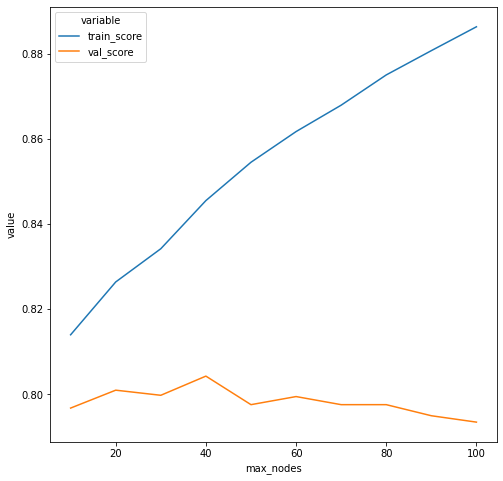

In [4]:
scores_df = dt_max_nodes_df[['max_nodes', 'train_score', 'val_score']]
scores_df = pd.melt(scores_df, 'max_nodes')

fig = plt.figure(figsize = (8,8))
sns.lineplot(x = 'max_nodes', y = 'value', hue = 'variable', data = scores_df, sizes = (0,1))

## Ovefitting:
It can be observed that the overfitting influences the validation score negatively for max_leaf_nodes above 40, therefore, the model on index 3 was selected for the testing phase.

In [5]:
selected_dt_model = fitted_model[3]

# Test set evaluation

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


y_prediction = selected_dt_model.predict(X_test)

acc = accuracy_score(y_test, y_prediction)
c_m = confusion_matrix(y_test, y_prediction)
sensibility = c_m[1,1]/sum(y_test == 1)
specificity = c_m[0,0]/sum(y_test == 0)

print('Test accuracy: ' + str(round(acc, 4)))
print('Test sensitivity: ' + str(round(sensibility, 4)))
print('Test specificity: ' + str(round(specificity, 4)))

Test accuracy: 0.7845
Test sensitivity: 0.3088
Test specificity: 0.9258


<AxesSubplot:>

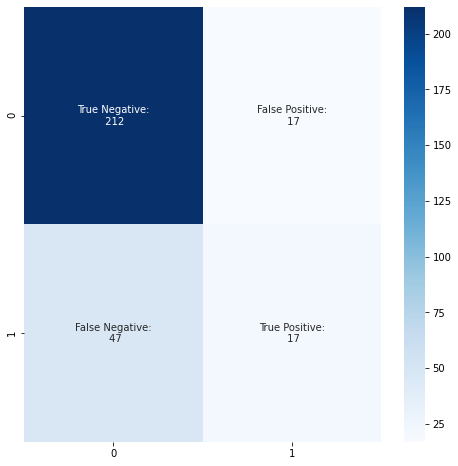

In [7]:
c_m
label_0_0 = "True Negative:\n " + str(c_m[0,0])
label_0_1 = "False Positive:\n " + str(c_m[0,1])
label_1_0 = "False Negative:\n " + str(c_m[1,0])
label_1_1 = "True Positive:\n " + str(c_m[0,1])

labels = [[label_0_0, label_0_1],[label_1_0, label_1_1]]

fig = plt.figure(figsize = (8,8))
sns.heatmap(c_m, annot = labels, fmt = '', cmap = 'Blues')

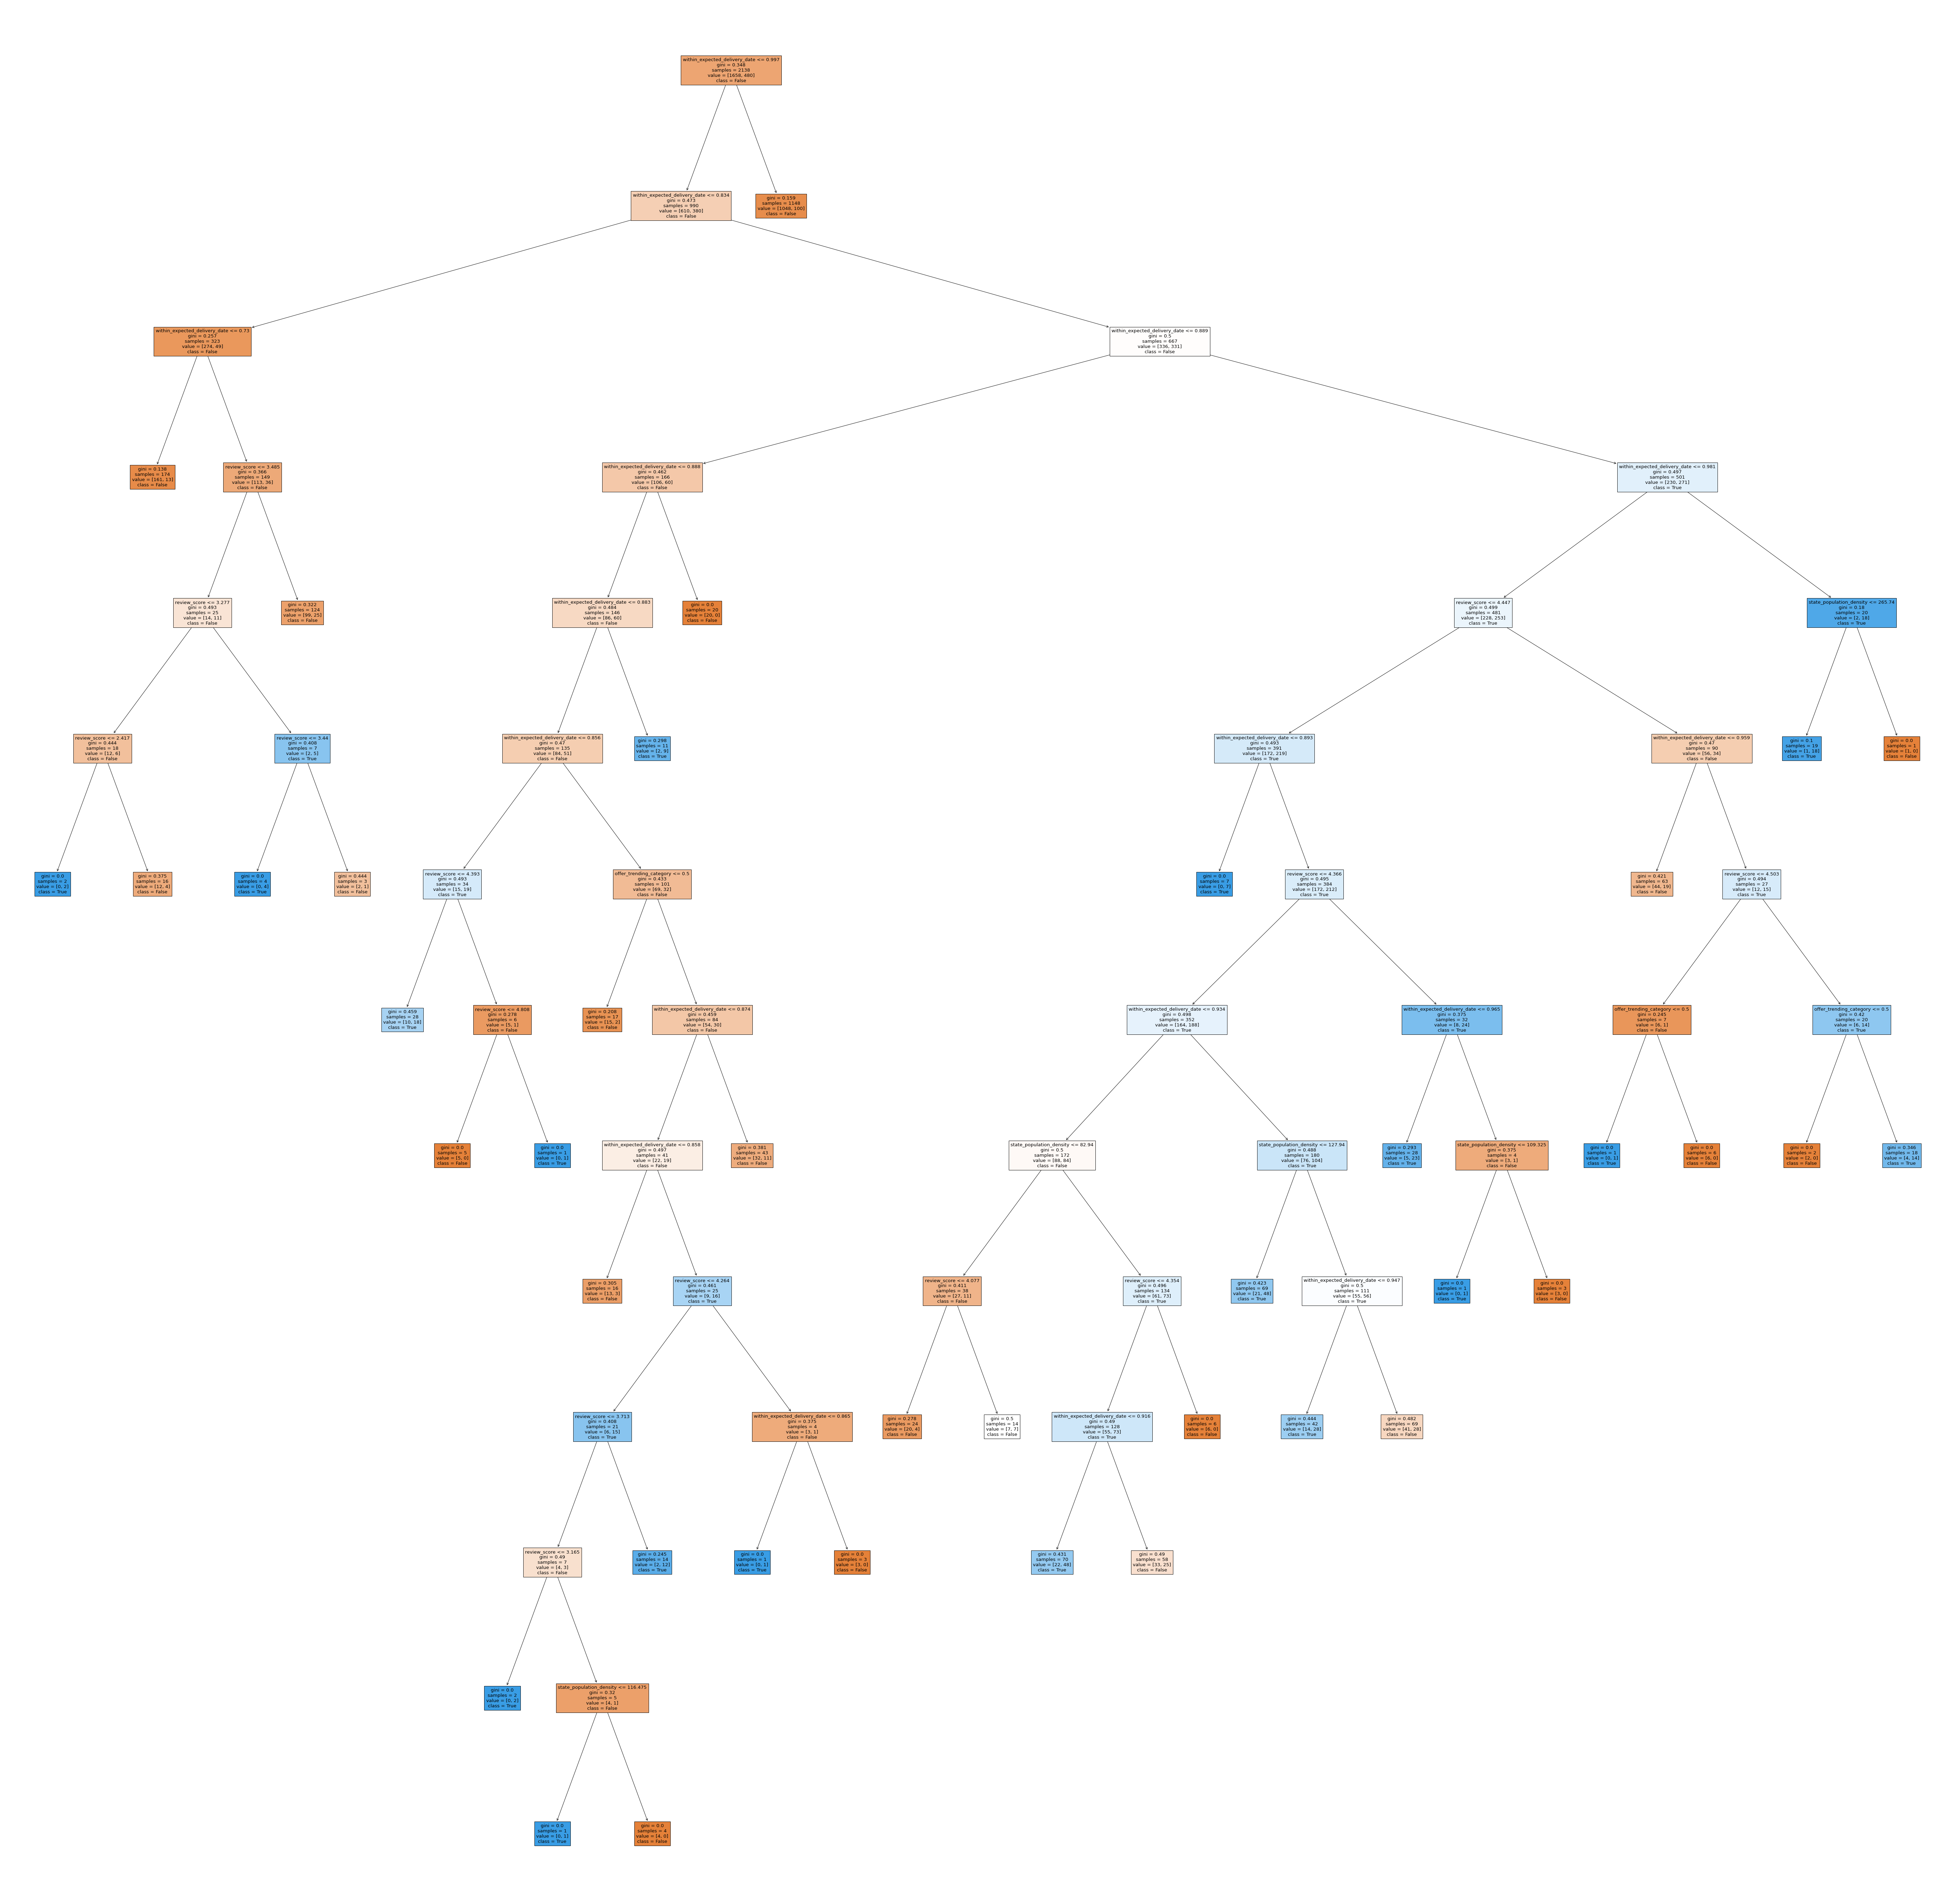

In [15]:
from sklearn import tree

features = ['within_expected_delivery_date'
                                  , 'review_score'
                                  , 'offer_trending_category'
                                  , 'state_population_density']

fig = plt.figure(figsize = (100,100))
tree.plot_tree(selected_dt_model
               , feature_names = features
               , class_names = ['False', 'True']
               , filled = True)
plt.show()

In [9]:
gini_importance = selected_dt_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'gini_importance' : gini_importance})
feature_importance.sort_values(by = 'gini_importance', ascending = False)

,feature,gini_importance
0,within_expected_delivery_date,0.799748
1,review_score,0.131082
3,state_population_density,0.047108
2,offer_trending_category,0.022062


In [10]:
sum(y_test == 1)/len(y_test)

0.22895622895622897

In [11]:
sum(y_test == 0)/len(y_test)

0.7710437710437711

In [12]:
sum(y_prediction == 1)/len(y_test)

0.12794612794612795

In [13]:
sum(y_prediction == 0)/len(y_test)

0.8720538720538721